Total rows after filtering: 2165


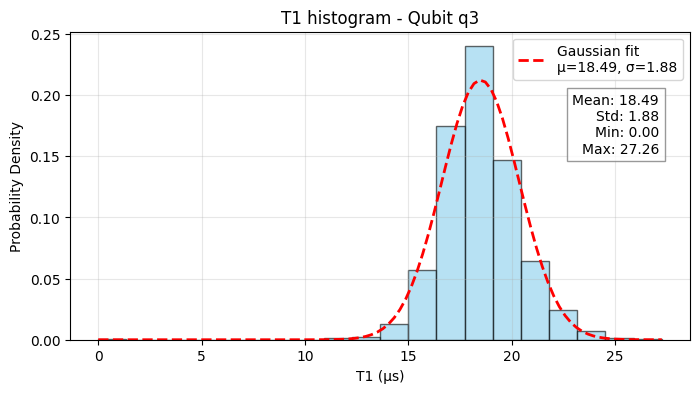

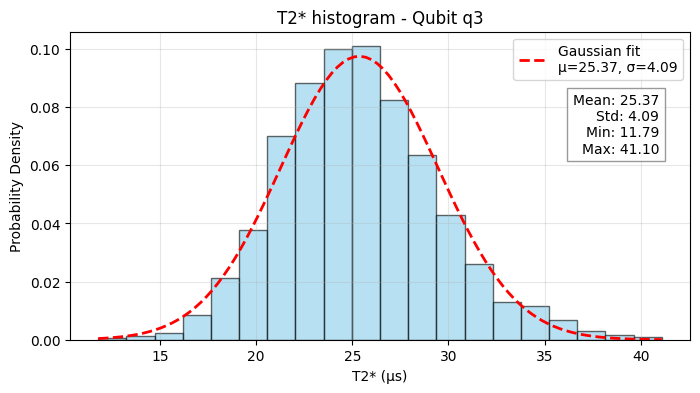

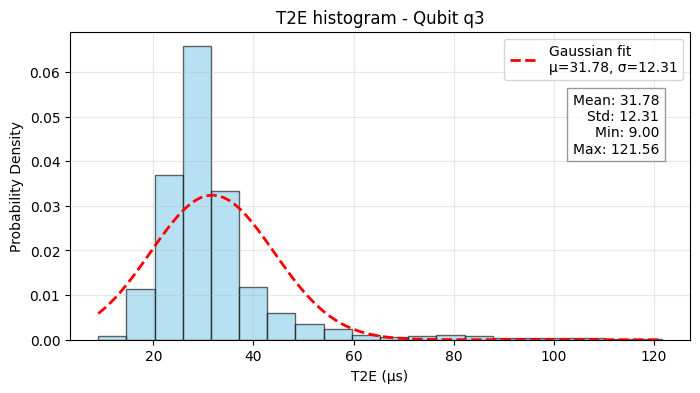

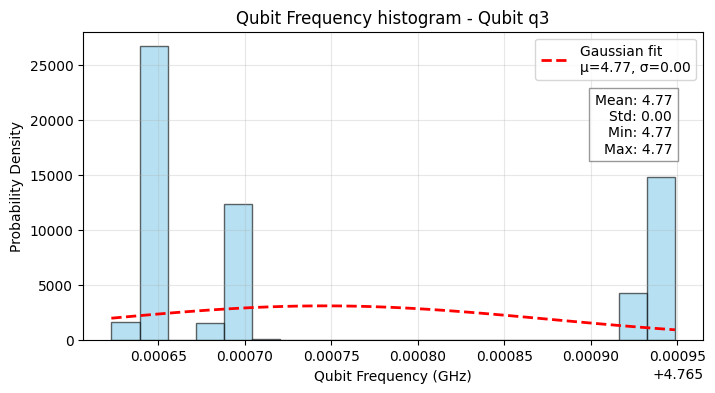

In [2]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# --- User configuration ---
QPU_NAME = "QPU149"
QUBIT_NAME = "q3"          
DATASET_ROOT = "../monitoring_packages/datasets"  
MAX_VALUES = {"T1": None, "T2*": 100, "T2E": None, "Qubit Frequency": None}
BINS = 20 # Número de barras para los histogramas - ARGUMENTO

# --- 1. Read CSVs ---
dataset_dir = Path(DATASET_ROOT) / f"datasets_{QPU_NAME}"
if not dataset_dir.exists():
    raise FileNotFoundError(f"Dataset directory does not exist: {dataset_dir}")

csv_files = sorted(dataset_dir.glob(f"*_{QUBIT_NAME}.csv"))
if not csv_files:
    raise FileNotFoundError(f"No CSV files found for {QUBIT_NAME} in {dataset_dir}")

dfs = []
for f in csv_files:
    df = pd.read_csv(f, dtype={"Timestamp": str})
    # Filter invalid values
    df = df[(df["T1"] > 0) & (df["T2*"] > 0) & (df["T2E"] > 0)]
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
print(f"Total rows after filtering: {len(df_all)}")

# --- 2. Prepare metrics and units ---
metrics = ["T1", "T2*", "T2E", "Qubit Frequency"]
unit_conv = {"T1": 1e6, "T2*": 1e6, "T2E": 1e6, "Qubit Frequency": 1e-9}

# Apply max value filters
for metric, max_val in MAX_VALUES.items():
    if max_val is not None:
        df_all = df_all[df_all[metric] * unit_conv[metric] <= max_val]

# --- 3. Build histograms with Gaussian ---
for metric in metrics:
    values = df_all[metric] * unit_conv[metric] # Extrae los valores de la metrica y aplica conversión de unidades

    # Gaussian distribution fit
    mu, sigma = norm.fit(values)

    # Normalized histogram (so that the total area equals 1 → compatible with the Gaussian curve)
    plt.figure(figsize=(8, 4))
    count, bins, ignored = plt.hist(values, bins=BINS, density=True, alpha=0.6, color='skyblue', edgecolor='black')

    # Adjusted Gaussian curve
    x = np.linspace(values.min(), values.max(), 100)
    plt.plot(x, norm.pdf(x, mu, sigma), 'r--', linewidth=2, label=f'Gaussian fit\nμ={mu:.2f}, σ={sigma:.2f}')

    plt.title(f"{metric} histogram - Qubit {QUBIT_NAME}")
    plt.xlabel(f"{metric} ({'µs' if metric != 'Qubit Frequency' else 'GHz'})")
    plt.ylabel("Probability Density")
    plt.grid(alpha=0.3)
    plt.legend()

    # Aditional statistics box
    plt.text(0.95, 0.8,
             f"Mean: {values.mean():.2f}\nStd: {values.std():.2f}\nMin: {values.min():.2f}\nMax: {values.max():.2f}",
             ha="right", va="top", transform=plt.gca().transAxes,
             bbox=dict(facecolor="white", alpha=0.8, edgecolor="gray"))

    plt.show()
